## **Deep Learning: Computer Vision**

This project builds artificial intelligence algorithms to label satellite image chips with different atmospheric conditions and the different classes of land cover/land use. This is a multi-label classification problem and has labels from the following categories: cloud cover (clear, partly, cloudy, haze), primary rainforest, water (rivers, lakes), habitation (large city, small homes), agriculture, roads etc.

This project titled “Planet: Understanding the Amazon from Space” was completed on kaggle as it is considerably computationally expensive.

The algorithms will enable in understanding where, how and why deforestation happens in the Amazon Rainforests. 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/planets-dataset/test-jpg-additional/test-jpg-additional/file_11658.jpg
/kaggle/input/planets-dataset/test-jpg-additional/test-jpg-additional/file_12808.jpg
/kaggle/input/planets-dataset/test-jpg-additional/test-jpg-additional/file_10513.jpg
/kaggle/input/planets-dataset/test-jpg-additional/test-jpg-additional/file_9859.jpg
/kaggle/input/planets-dataset/test-jpg-additional/test-jpg-additional/file_1194.jpg
/kaggle/input/planets-dataset/test-jpg-additional/test-jpg-additional/file_3078.jpg
/kaggle/input/planets-dataset/test-jpg-additional/test-jpg-additional/file_2870.jpg
/kaggle/input/planets-dataset/test-jpg-additional/test-jpg-additional/file_11474.jpg
/kaggle/input/planets-dataset/test-jpg-additional/test-jpg-additional/file_3889.jpg
/kaggle/input/planets-dataset/test-jpg-additional/test-jpg-additional/file_3152.jpg
/kaggle/input/planets-dataset/test-jpg-additional/test-jpg-additional/file_7066.jpg
/kaggle/input/planets-dataset/test-jpg-additional/test-jpg-additional/fi

In [2]:
import os
import sys
import pandas as pd
import numpy as np
from tqdm import tqdm    # To read in images in batches and see progress
import pathlib
import scipy
import subprocess
import gc   # Garbage collector module for memory management

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import cv2    #OpenCV for image manipulation

from tensorflow import keras  #We need keras library
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator  #Used for Data augmentation
from keras import backend as K   #For specialized and optimized tensor manipulation

from sklearn.utils import shuffle
from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split  # For the creation of training and validation sets

#from six import string_types
#from IPython.display import display
#from keras.preprocessing import image as image_utils
#from keras import applications

In [3]:
!ls /kaggle/input/

planets-dataset


In [4]:
!ls /kaggle/input/planets-dataset/

planet	test-jpg-additional


Exploratory data analysis



In [5]:
# Using DataFrame to check the shape of the training set, and their tags (labels that may be assigned) for each image
train_df = pd.read_csv('../input/planets-dataset/planet/planet/train_classes.csv')
train_df.columns = ["image_name", "tags"]
train_df

# We can see that there are indeed 40,479 training images mapped to tags.
# The second column of the sample.csv mapped each image to a tag of possible labels (separated by a space for each), that can be assigned to each image.

image_name                                           tags
0          train_0                                   haze primary
1          train_1                agriculture clear primary water
2          train_2                                  clear primary
3          train_3                                  clear primary
4          train_4      agriculture clear habitation primary road
...            ...                                            ...
40474  train_40474                                  clear primary
40475  train_40475                                         cloudy
40476  train_40476                      agriculture clear primary
40477  train_40477                 agriculture clear primary road
40478  train_40478  agriculture cultivation partly_cloudy primary

[40479 rows x 2 columns]

In [6]:
test_df = pd.read_csv('../input/planets-dataset/planet/planet/sample_submission.csv')
test_df

image_name                                  tags
0         test_0  primary clear agriculture road water
1         test_1  primary clear agriculture road water
2         test_2  primary clear agriculture road water
3         test_3  primary clear agriculture road water
4         test_4  primary clear agriculture road water
...          ...                                   ...
61186  file_9995  primary clear agriculture road water
61187  file_9996  primary clear agriculture road water
61188  file_9997  primary clear agriculture road water
61189  file_9998  primary clear agriculture road water
61190  file_9999  primary clear agriculture road water

[61191 rows x 2 columns]

In [7]:
# TAG SPLITTING: Creating a list of all known tags to be assigned to the images by looping through each row in 
# the “tags” column of the train set, splitting the tags by space, and storing them in a set
label_list = []
for tag_str in train_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

            
# Display label list and number of labels in the dataset
print(f'The number of data samples is {len(train_df)}. And there are {len(label_list)} unique possible classes.', '\n' 
      f'The Label list includes {label_list}')

The number of data samples is 40479. And there are 17 unique possible classes. 
The Label list includes ['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down']


In [8]:
# Creating a dictionary to map tags to integer so we encode and use them for modeling
# Assign a unique and consistent integer to each tag to be used to develop a target vector for each image with a One-hot encoding.
flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in train_df['tags'].values])))


# Creating a label map
label_map = {l: i for i, l in enumerate(labels)}

print(f'label_map = {label_map},\n length = {len(label_map)}')

label_map = {'water': 0, 'primary': 1, 'cloudy': 2, 'clear': 3, 'cultivation': 4, 'artisinal_mine': 5, 'blow_down': 6, 'conventional_mine': 7, 'blooming': 8, 'selective_logging': 9, 'habitation': 10, 'haze': 11, 'bare_ground': 12, 'partly_cloudy': 13, 'road': 14, 'agriculture': 15, 'slash_burn': 16},
 length = 17


In [9]:
# Creating a target vector by applying one hot encoding to the unique labels --- e.g [0 0 0 1 0 0 0 0 0 0] for "bare_ground" tag.
train_tag_data = train_df.copy()
for label in label_list:
    train_tag_data[label] = train_tag_data['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)

# Display head
train_tag_data.head()

image_name                                       tags  haze  primary  \
0    train_0                               haze primary     1        1   
1    train_1            agriculture clear primary water     0        1   
2    train_2                              clear primary     0        1   
3    train_3                              clear primary     0        1   
4    train_4  agriculture clear habitation primary road     0        1   

   agriculture  clear  water  habitation  road  cultivation  slash_burn  \
0            0      0      0           0     0            0           0   
1            1      1      1           0     0            0           0   
2            0      1      0           0     0            0           0   
3            0      1      0           0     0            0           0   
4            1      1      0           1     1            0           0   

   cloudy  partly_cloudy  conventional_mine  bare_ground  artisinal_mine  \
0       0              0                  0            0               0   
1       0              0                  0            0               0   
2       0              0                  0            0               0   
3       0              0                  0            0               0   
4       0              0                  0            0               0   

   blooming  selective_logging  blow_down  
0         0                  0          0  
1         0                  0          0  
2         0                  0          0  
3         0                  0          0  
4         0                  0          0

In [10]:

# Printing decreasing frequenciy of instances for each category
category_counts = {}

for column in train_tag_data.columns[2:]:
     category_counts[column] = train_tag_data[column].value_counts()[1]

for w in sorted(category_counts, key=category_counts.get, reverse=True):
    print(category_counts[w] , w )

37513 primary
28431 clear
12315 agriculture
8071 road
7411 water
7261 partly_cloudy
4477 cultivation
3660 habitation
2697 haze
2089 cloudy
862 bare_ground
340 selective_logging
339 artisinal_mine
332 blooming
209 slash_burn
100 conventional_mine
98 blow_down


In [11]:
# Print all unique tags
from itertools import chain
labels_list = list(chain.from_iterable([labels.split(" ") for labels in train_tag_data['tags'].values]))
labels_set = set(labels_list)
print("There is {} unique labels including {}".format(len(labels_set), labels_set))


There is 17 unique labels including {'water', 'primary', 'cloudy', 'clear', 'cultivation', 'artisinal_mine', 'blow_down', 'conventional_mine', 'blooming', 'selective_logging', 'habitation', 'haze', 'bare_ground', 'partly_cloudy', 'road', 'agriculture', 'slash_burn'}


## **Visualizing the dataset to compare frequency of occurence**, Using:
+ bar plot
+ coocurence matrix

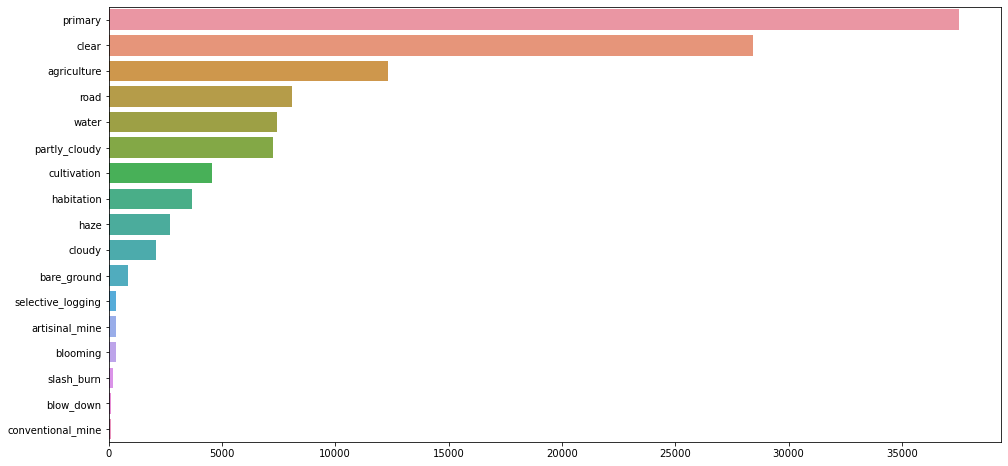

In [12]:
# Plotting a Histogram of label instances
tag_labels = pd.Series(labels_list).value_counts() # To sort them by count
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=tag_labels, y=tag_labels.index, orient='h')

haze  primary  agriculture  clear  water  habitation  road  \
haze               2697     2670          672      0    613         129   394   
primary            2670    37513        11972  27668   7001        3469  7728   
agriculture         672    11972        12315   9150   2712        2737  6034   
clear                 0    27668         9150  28431   5502        3090  6295   
water               613     7001         2712   5502   7411         915  2125   
habitation          129     3469         2737   3090    915        3660  2786   
road                394     7728         6034   6295   2125        2786  8071   
cultivation         202     4455         3377   3527    868         895  1294   
slash_burn            3      209          119    173     24          41    36   
cloudy                0        0            0      0      0           0     0   
partly_cloudy         0     7175         2493      0   1295         441  1382   
conventional_mine     2       94           24     70     26          36    59   
bare_ground          41      683          225    747    206         163   323   
artisinal_mine        5      324           38    307    299          29   110   
blooming              4      332           32    311     16           4    10   
selective_logging     5      340           65    308     49          13   151   
blow_down             0       98           22     85      3           3     2   

                   cultivation  slash_burn  cloudy  partly_cloudy  \
haze                       202           3       0              0   
primary                   4455         209       0           7175   
agriculture               3377         119       0           2493   
clear                     3527         173       0              0   
water                      868          24       0           1295   
habitation                 895          41       0            441   
road                      1294          36       0           1382   
cultivation               4477         126       0            748   
slash_burn                 126         209       0             33   
cloudy                       0           0    2089              0   
partly_cloudy              748          33       0           7261   
conventional_mine            4           0       0             28   
bare_ground                 89          10       0             74   
artisinal_mine              18           0       0             27   
blooming                    35           2       0             17   
selective_logging           58           2       0             27   
blow_down                    8           2       0             13   

                   conventional_mine  bare_ground  artisinal_mine  blooming  \
haze                               2           41               5         4   
primary                           94          683             324       332   
agriculture                       24          225              38        32   
clear                             70          747             307       311   
water                             26          206             299        16   
habitation                        36          163              29         4   
road                              59          323             110        10   
cultivation                        4           89              18        35   
slash_burn                         0           10               0         2   
cloudy                             0            0               0         0   
partly_cloudy                     28           74              27        17   
conventional_mine                100           10               4         0   
bare_ground                       10          862              40         3   
artisinal_mine                     4           40             339         0   
blooming                           0            3               0       332   
selective_logging                  0           13    

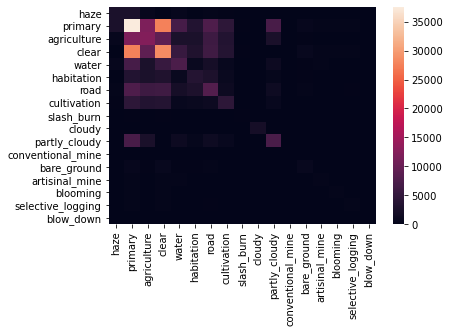

In [13]:
# function for cooocurence matrix plotting
def make_cooccurence_matrix(labels):
    numeric_data = train_tag_data[labels]; 
    c_matrix = numeric_data.T.dot(numeric_data)
    sns.heatmap(c_matrix)
    return c_matrix
    
# Compute the co-ocurrence matrix
make_cooccurence_matrix(label_list)

Each image should have exactly one weather label:

primary  agriculture  water  cultivation  habitation
primary        37513        11972   7001         4455        3469
agriculture    11972        12315   2712         3377        2737
water           7001         2712   7411          868         915
cultivation     4455         3377    868         4477         895
habitation      3469         2737    915          895        3660

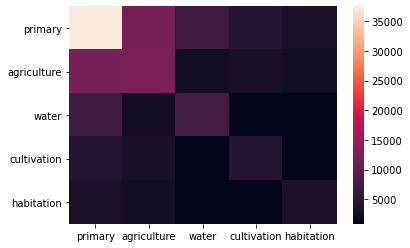

In [14]:
# plot land-use element classes cooccurence matrix
land_labels = ['primary', 'agriculture', 'water', 'cultivation', 'habitation']
make_cooccurence_matrix(land_labels)

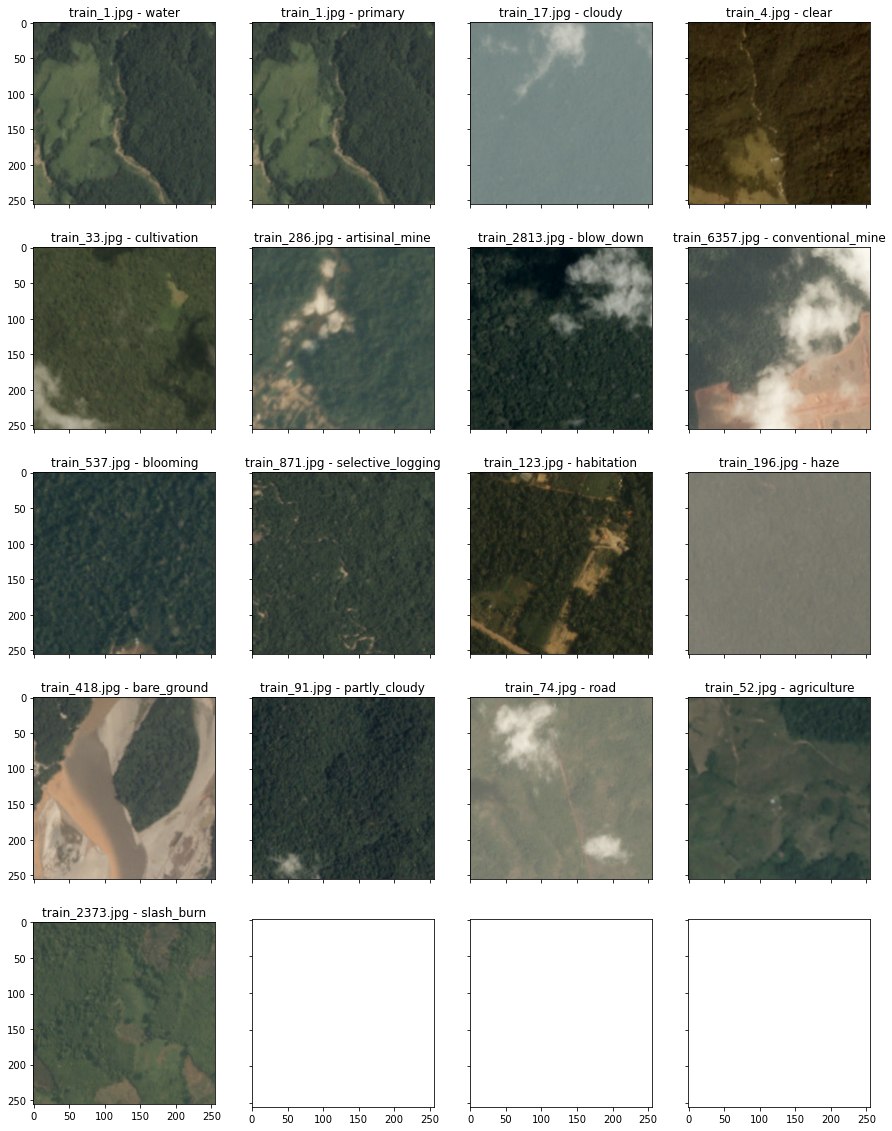

In [15]:
# Loading and visualizing one image in each category (or label) of the  training dataset using matplotlib
images = [train_df[train_df['tags'].str.contains(label)].iloc[i]['image_name'] + '.jpg' 
                for i, label in enumerate(labels_set)]

plt.rc('axes', grid=False)
_, axs = plt.subplots(5, 4, sharex='col', sharey='row', figsize=(15, 20))
axs = axs.ravel()

# /kaggle/input/planets-dataset/planet/planet/train_classes.csv
# /kaggle/input/planets-dataset/planet/planet/train-jpg

for i, (image_name, label) in enumerate(zip(images, labels_set)):
    img = mpimg.imread('../input/planets-dataset/planet/planet/train-jpg' + '/' + image_name)
    axs[i].imshow(img)
    axs[i].set_title('{} - {}'.format(image_name, label))

In [16]:
# Determining if the length of the train and test dataset csv file equals the actual number of images in the folder

# Assign train and the two test dataset paths
# train path
train_img_dir = pathlib.Path('../input/planets-dataset/planet/planet/train-jpg')
train_img_path = sorted(list(train_img_dir.glob('*.jpg')))


# Let's read in the test image dataset and merge the test_additional jpg file to give an output of 61191 rows
# test path
test_img_dir = pathlib.Path('../input/planets-dataset/planet/planet/test-jpg')
test_img_path = sorted(list(test_img_dir.glob('*.jpg')))

# additional test path
test_add_img_dir = pathlib.Path('../input/planets-dataset/test-jpg-additional')
test_add_img_path = sorted(list(test_add_img_dir.glob('*/*.jpg')))

# Length Confirmation
assert len(train_img_path) == len(train_df)
print(len(test_img_path)+len(test_add_img_path))

61191


## IMAGE PREPROCESSING

In [17]:
# define input size. Data Length Check (or checking smapple size)
input_size = 64

In [18]:
x_train = []
y_train = []

for f, tags in tqdm(train_df.values, miniters=1000):
    img = cv2.imread('../input/planets-dataset/planet/planet/train-jpg/{}.jpg'.format(f))
    img = cv2.resize(img, (input_size, input_size))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1
    x_train.append(img)
    y_train.append(targets)
        
x_train = np.array(x_train, np.float32)
y_train = np.array(y_train, np.uint8)

print(x_train.shape)
print(y_train.shape)

100%|██████████| 40479/40479 [02:17<00:00, 293.80it/s]


(40479, 64, 64, 3)
(40479, 17)


In [19]:
# creating x_test
x_test = []

test_jpg_dir = '../input/planets-dataset/planet/planet/test-jpg'
test_image_names = os.listdir(test_jpg_dir)

n_test = len(test_image_names)
test_classes = test_df.iloc[:n_test, :]
add_classes = test_df.iloc[n_test:, :]


test_jpg_add_dir = '../input/planets-dataset/test-jpg-additional/test-jpg-additional'
test_add_image_names = os.listdir(test_jpg_add_dir)

for img_name, _ in tqdm(test_classes.values, miniters=1000):
    img = cv2.imread(test_jpg_dir + '/{}.jpg'.format(img_name))
    x_test.append(cv2.resize(img, (64, 64)))
    
for img_name, _ in tqdm(add_classes.values, miniters=1000):
    img = cv2.imread(test_jpg_add_dir + '/{}.jpg'.format(img_name))
    x_test.append(cv2.resize(img, (64, 64)))

x_test = np.array(x_test, np.float32)
print(x_test.shape)

100%|██████████| 20522/20522 [01:08<00:00, 298.04it/s]


(61191, 64, 64, 3)


In [20]:
gc.collect()

40

In [21]:
# split the train data into train and validation data sets
X_train = x_train[ :35000]
Y_train = y_train[ :35000]

X_valid = x_train[35000: ]
Y_valid = y_train[35000: ]

## Building the Model Architecture
+ A combination of a custom deep CNN architecture is combined with a pre-trained CNN architecture(VGG16) will be implemented in Keras with Tensorflow backend

In [22]:
# specify sizes (batch and model input) and number of input channels
input_size = 64
input_channels = 3
batch_size = 64

In [23]:
model = Sequential()

# Input layer
model.add(BatchNormalization(input_shape=(input_size, input_size, input_channels)))

# CCM_1
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#CCM_2
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
 
#CCM_3
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
 
#CCM_4
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


# Create a feature vector from the CCM_4 final layer
model.add(Flatten())

# Fully Connected (FC) Layer
model.add(Dense(512, activation='relu'))
model .add(BatchNormalization())
model.add(Dropout(0.5))

# Output layer
model.add(Dense(17, activation='sigmoid'))

In [24]:
import tensorflow.keras as keras
# Loading the pre-trained VGG16 architecture module
from tensorflow.keras.applications.vgg16 import VGG16



# Extract the pre - trained architecture
base_model = VGG16(input_shape =(input_size,input_size,3),include_top =False,weights ='imagenet')
base_model.summary()

# Get the output of the base_model formed above
x = base_model.output
# Flatten to obtain a feature vector
x = Flatten()(x)
# Connect the feature vector to to the fully connected (FC) layer
x = Dense (512 , activation ='relu')(x)
# Form the output label predictions
predictions = Dense (17 , activation ='sigmoid')(x)
model = Model(inputs= base_model.input,outputs = predictions)

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
______________________________________________________________

In [25]:
gc.collect()

20

In [26]:
# Implementing ImageDataGenerator for data augmentation. This is an important technique which reduces 
# overfitting as it generates extra images by flipping, cropping, zooming e,t.c the images. This makes 
# the model have more images to learn from.

datagen = ImageDataGenerator ( horizontal_flip =True ,
vertical_flip =True ,
zoom_range =0.2,
rotation_range =90 ,
fill_mode ='reflect')

In [27]:
# Defining other parameters
epochs=20 # An epoch is one complete pass through the training data, Here, epoch is set equals 20

optimizer = keras.optimizers.Adam(learning_rate=0.0001) # Defining our Adam optimizer and learning rate

In [28]:
# Define the fbeta metric
def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 2
 
    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)
 
    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)
 
    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))
 
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
 
    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

In [29]:
model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=[fbeta])


callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=0),
                ModelCheckpoint(filepath='weights/best_weights',
                                 save_best_only=True,
                                 save_weights_only=True)]


In [30]:
gc.collect()

20

## Model Training: Fit the Model

In [31]:
# The code below fits the model while generating extra images with the Imagedatagenerator, and then fit them. 
model.fit_generator(datagen.flow(X_train,
Y_train,
batch_size =24),
steps_per_epoch =len(X_train)/32 ,
validation_data = datagen.flow ( X_valid,
Y_valid,
batch_size =24),
validation_steps =len(X_valid)/32 ,
epochs =epochs ,
callbacks = callbacks ,
verbose =1)

Epoch 1/20
1094/1093 [==============================] - 54s 50ms/step - loss: 0.1508 - fbeta: 0.7908 - val_loss: 0.1470 - val_fbeta: 0.7908
Epoch 2/20
1094/1093 [==============================] - 54s 50ms/step - loss: 0.1231 - fbeta: 0.8309 - val_loss: 0.1201 - val_fbeta: 0.8325
Epoch 3/20
1094/1093 [==============================] - 56s 51ms/step - loss: 0.1175 - fbeta: 0.8389 - val_loss: 0.1152 - val_fbeta: 0.8332
Epoch 4/20
1094/1093 [==============================] - 55s 50ms/step - loss: 0.1127 - fbeta: 0.8464 - val_loss: 0.1159 - val_fbeta: 0.8460
Epoch 5/20
1094/1093 [==============================] - 56s 51ms/step - loss: 0.1112 - fbeta: 0.8497 - val_loss: 0.1122 - val_fbeta: 0.8461
Epoch 6/20
1094/1093 [==============================] - 56s 51ms/step - loss: 0.1091 - fbeta: 0.8517 - val_loss: 0.1080 - val_fbeta: 0.8634
Epoch 7/20
1094/1093 [==============================] - 56s 51ms/step - loss: 0.1064 - fbeta: 0.8571 - val_loss: 0.1064 - val_fbeta: 0.8532
Epoch 8/20
1094/1093

In [32]:
gc.collect()

24

In [33]:
# Prediction with the trained model using the test data
test_1 =[]
test_1.append (model.predict (x_test , batch_size = 128 , verbose =2) ) 


479/479 - 11s


In [34]:
# After prediction, we compile the results in a pandas dataframe form
result = np.array (test_1[0])
for i in range (1,len(test_1) ):
 result += np. array (test_1)
result = pd.DataFrame (result,columns = labels )

In [35]:
result

water   primary        cloudy     clear  cultivation  \
0      0.007891  0.999935  6.629604e-06  0.997089     0.004382   
1      0.008038  0.999934  5.029961e-06  0.997521     0.005270   
2      0.098297  0.999975  2.432797e-05  0.000062     0.007977   
3      0.369951  0.999759  7.003313e-05  0.340794     0.169619   
4      0.097376  0.988449  1.072245e-02  0.001851     0.009809   
...         ...       ...           ...       ...          ...   
61186  0.053537  0.386386  6.405602e-01  0.001592     0.008089   
61187  0.971087  0.999002  2.719103e-05  0.995537     0.018200   
61188  0.211797  0.999845  8.558082e-06  0.996911     0.007059   
61189  0.011860  0.162789  8.373054e-01  0.003715     0.000294   
61190  0.043546  0.965271  1.305781e-07  0.998733     0.003380   

       artisinal_mine     blow_down  conventional_mine      blooming  \
0        2.572823e-06  1.987701e-03       1.680983e-06  6.213161e-02   
1        4.472130e-06  3.953604e-03       2.625539e-06  1.341884e-01   
2        1.562077e-06  4.373084e-04       5.564503e-06  1.496252e-04   
3        2.895700e-04  5.608622e-03       5.357178e-04  5.215097e-03   
4        1.005230e-05  5.718134e-04       7.254715e-05  6.518768e-04   
...               ...           ...                ...           ...   
61186    3.768698e-05  6.588403e-06       6.316230e-05  6.473444e-06   
61187    3.665047e-04  7.066132e-04       1.539801e-04  1.684413e-02   
61188    1.168191e-05  1.291570e-03       1.837040e-05  8.422455e-03   
61189    8.534997e-07  3.407031e-08       3.350527e-08  1.718750e-07   
61190    6.994756e-05  8.453253e-07       2.782227e-04  2.654827e-06   

       selective_logging  habitation      haze  bare_ground  partly_cloudy  \
0               0.005248    0.006464  0.000383     0.000171       0.001849   
1               0.013526    0.010300  0.000264     0.000275       0.001705   
2               0.000915    0.002352  0.000009     0.000020       0.999714   
3               0.013046    0.016561  0.001102     0.004053       0.765703   
4               0.000815    0.005667  0.002151     0.000438       0.982149   
...                  ...         ...       ...          ...            ...   
61186           0.000057    0.007160  0.001473     0.000415       0.505302   
61187           0.009364    0.060889  0.000806     0.006808       0.002469   
61188           0.003868    0.008614  0.000266     0.000666       0.002823   
61189           0.000006    0.000237  0.196677     0.000008       0.001073   
61190           0.000533    0.999201  0.000289     0.002073       0.000537   

           road  agriculture    slash_burn  
0      0.008775     0.010623  5.225447e-05  
1      0.009522     0.015113  8.417902e-05  
2      0.027730     0.043854  1.785903e-05  
3      0.210236     0.378617  3.291570e-03  
4      0.027450     0.036521  9.591455e-05  
...         ...          ...           ...  
61186  0.021525     0.036944  5.353343e-05  
61187  0.279137     0.078283  1.047836e-03  
61188  0.184772     0.022526  1.885985e-04  
61189  0.002951     0.001261  1.328251e-07  
61190  0.985854     0.343248  8.942144e-06  

[61191 rows x 17 columns]

In [36]:
preds = []
for i in tqdm(range(result.shape[0]), miniters=1000):
    a = result.loc[[i]]
    a = a.apply(lambda x: x > 0.2, axis=1)
    a = a.transpose()
    a = a.loc[a[i] == True]
    ' '.join(list(a.index))
    preds.append(' '.join(list(a.index)))
    

100%|██████████| 61191/61191 [02:31<00:00, 404.30it/s]


In [37]:
# The submission csv
test_df['tags'] = preds
test_df.to_csv('amazon_submission11.csv', index=False)